# Investigate temperature change potential of different aerosol forcing time series


## TODO in revision
- ~~Nitrate aerosol: competition with sulfate. May not be a great deal of models but at least we can do Oslo-CTM3~~
- Percentile matching ERFari and ERFaci: at least report weighted mean as headline values as sum of weighted percentiles != weighted percentiles of sum (but this does seem to hold for weighted means).
- correlations between ERFari and ERFaci in CMIP6 models
- carbon brief want my take on it - let them know when accepted
- make this into a self-contained GitHub repo
- run RFMIP all forcing expts in two layer model
- fix BC on snow uncertainty

This is a bit circular as we need the non-aerosol forcing first. Could come after the AR6

In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as pl
import os
import urllib
import json
import wquantiles
from matplotlib import rc
from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde
from scipy.optimize import root
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from fair.forcing.ghg import etminan
from fair.constants import molwt
from fair.constants.general import EARTH_RADIUS
import tqdm.autonotebook as tqdman
from scipy.signal import savgol_filter
from netCDF4 import Dataset
import matplotlib.gridspec as gridspec
import random

from ar6.utils.h5 import *
from ar6.utils.statistics import rmse, weighted_percentile
from ar6.utils.ensemble import knutti_score, simple_weight
from ar6.utils import check_and_download

from openscm_units import unit_registry as ur
from scmdata import ScmRun, run_append

import openscm_twolayermodel
from openscm_twolayermodel import ImpulseResponseModel, TwoLayerModel
from openscm_twolayermodel.base import Model

import h5py

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
pl.rcParams['figure.figsize'] = (12/2.54, 12/2.54)
pl.rcParams['font.size'] = 8
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['figure.dpi'] = 96

## Earth system heat uptake from Matt Palmer

Use OHU/0.9 for total earth uptake
this replaces von Schuckmann

In [3]:
df = pd.read_csv('../data_input/AR6_OHC_ensemble_FGDprelim.csv', skiprows=1)
OHCobs = df['Central Estimate Full-depth'].values/0.9
OHC90 = df['Full-depth Uncertainty (1-sigma)'].values/0.9
OHC90 = np.sqrt(OHC90[0]**2 + OHC90[-1]**2)

In [4]:
# Should I de-apply rapid adjustments to historical estimates? Climate models from 1850-2014 agree with Etminan with no adjustment
# no: we should keep the adjustments in
# make this precisely the SOD assessment

ssp245_allforcing = pd.read_csv('/nfs/see-fs-02_users/mencsm/ssp_erf/SSPs/ERF_ssp245_1750-2500.csv')  # to do change to FGD: need the non-aerosol forcing first!
baseline_forcing = ssp245_allforcing.copy()

baseline_forcing.drop(
    labels=['total_anthropogenic','total'],
    axis='columns',
    inplace=True
)
baseline_forcing['total_anthropogenic'] = baseline_forcing[['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','bc_on_snow','land_use','aerosol-radiation_interactions','aerosol-cloud_interactions']].sum(axis=1)
baseline_forcing['total'] = baseline_forcing['total_anthropogenic'] + baseline_forcing['total_natural']
pd.set_option('display.max_rows', 999)
baseline_forcing

,year,co2,ch4,n2o,other_wmghg,o3_tropospheric,o3_stratospheric,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,total_natural,total_anthropogenic,total
0,1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.206975,0.073621,0.280596,0.000000,0.280596
1,1751,0.001571,0.000543,0.000086,7.958010e-10,0.000300,0.000000,0.000050,0.000000,-0.000537,0.004961,-0.000358,-0.000229,0.206987,0.055275,0.262262,0.006387,0.268649
2,1752,0.003142,0.001086,0.000173,1.591602e-09,0.000600,0.000000,0.000099,0.000000,-0.000840,0.007792,-0.000483,-0.000458,0.206991,0.025197,0.232188,0.011111,0.243300
3,1753,0.004712,0.001629,0.000259,2.387403e-09,0.000900,0.000000,0.000149,0.000000,-0.000566,0.004875,-0.000373,-0.000687,0.206993,-0.010981,0.196012,0.010898,0.206910
4,1754,0.006282,0.002171,0.000346,3.183204e-09,0.001200,0.000000,0.000198,0.000000,0.000129,-0.002529,0.000023,-0.000916,0.206993,-0.045395,0.161598,0.006904,0.168502
5,1755,0.007852,0.002713,0.000432,3.979005e-09,0.001500,0.000000,0.000248,0.000000,-0.000169,0.001146,0.000020,-0.001145,0.180025,-0.069873,0.110152,0.012597,0.122749
6,1756,0.009421,0.003255,0.000519,4.774806e-09,0.001800,0.000000,0.000297,0.000000,-0.000598,0.004323,-0.000417,-0.001374,-0.070676,-0.077455,-0.148131,0.017226,-0.130905
7,1757,0.010989,0.003796,0.000605,5.570607e-09,0.002100,0.000000,0.000347,0.000000,0.000570,-0.005952,0.000723,-0.001604,0.073348,-0.058313,0.015035,0.011575,0.026610
8,1758,0.012557,0.004337,0.000691,6.366408e-09,0.002400,0.000000,0.000396,0.000000,0.000137,-0.002135,0.000329,-0.001833,0.160265,-0.006956,0.153309,0.016881,0.170190
9,1759,0.014125,0.004878,0.000778,7.162209e-09,0.002700,0.000000,0.000446,0.000000,0.000238,-0.003323,0.000281,-0.002062,0.191213,0.043543,0.234757,0.018061,0.252817


Using assessed GMST / GSAT

In [5]:
xl = pd.read_excel('../data_input/Consolidated GMST time series.xlsx', skiprows=8, skipfooter=9)
Tobs=xl['5-set mean'][:-1].values
years=xl['Unnamed: 0'][:-1].values

-1.5782582212808597e-17
1.014904397254902


169

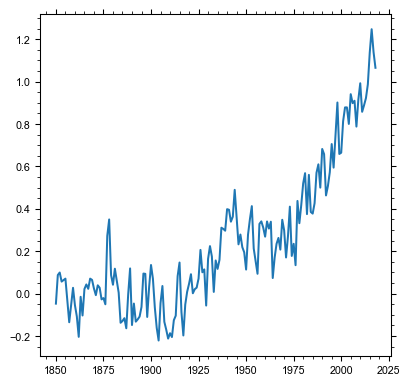

In [6]:
pl.plot(years, Tobs)
print(np.mean(Tobs[:51]))
print(np.mean(Tobs[159:169]))
len(Tobs)

## Simple experiment with ECS=3.7 and default Geoffroy params

In [7]:
with open("../data_output/cmip6_twolayer_tuning_params.json", "r") as read_file:
    cmip6_models = json.load(read_file)
cmip6_models['dl']['mean']

802.7537729867868

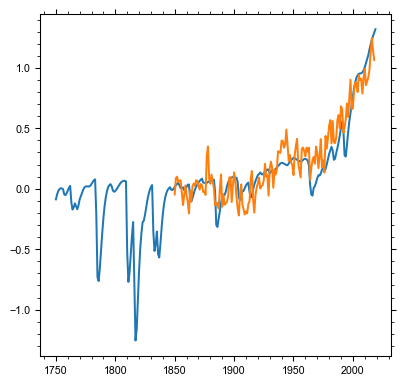

In [8]:
runner = TwoLayerModel()
runner.dl = cmip6_models['dl']['mean'] * ur(cmip6_models['dl']['units'])
runner.du = cmip6_models['du']['mean']  * ur(cmip6_models['du']['units'])
runner.eta = cmip6_models['eta']['mean'] * ur(cmip6_models['eta']['units'])
runner.lambda0 = cmip6_models['lambda0']['mean'] *  ur(cmip6_models['lambda0']['units'])
runner.efficacy = cmip6_models['efficacy']['mean'] * ur(cmip6_models['efficacy']['units'])

driver = ScmRun(
    data=baseline_forcing['total'][:270],
    index=np.arange(1750,2020),
    columns={
        "unit": "W/m^2",
        "model": "idealised",
        "scenario": "ssp245",
        "region": "World",
        "variable": "Effective Radiative Forcing",
    },
)
output = runner.run_scenarios(driver)
pl.plot(np.arange(1750,2020), output.filter(variable='Surface Temperature|Upper').relative_to_ref_period_mean(year=range(1850,1901)).timeseries().values.squeeze())
pl.plot(np.arange(1850,2019), Tobs)

In [9]:
params = pd.DataFrame({
    param:cmip6_models[param]['model_data'] for param in cmip6_models
})
params.drop(columns=['T4xCO2'], inplace=True)
params.corr()

,dl,du,eta,efficacy,lambda0,F4xCO2
dl,1.000000,0.617931,0.138834,-0.364489,0.416454,0.062794
du,0.617931,1.000000,-0.358705,-0.860692,0.335435,-0.180006
eta,0.138834,-0.358705,1.000000,0.335756,0.134440,0.284346
efficacy,-0.364489,-0.860692,0.335756,1.000000,-0.232162,0.325604
lambda0,0.416454,0.335435,0.134440,-0.232162,1.000000,0.476300
F4xCO2,0.062794,-0.180006,0.284346,0.325604,0.476300,1.000000


In [10]:
samples = 25000 # need list of variables and seeds
# need also to tune two layer model better

kde = st.gaussian_kde(params.T)
geoff_sample = kde.resample(size=int(samples*2), seed=3170812)
# remove unphysical combinations
geoff_sample[:,geoff_sample[0,:] <= 0] = np.nan
geoff_sample[:,geoff_sample[4,:] <= 0.5] = np.nan
geoff_sample[:,geoff_sample[2,:] <= 0] = np.nan
geoff_sample[:,geoff_sample[3,:] <= 0] = np.nan
geoff_sample[:,geoff_sample[5,:] <= 0] = np.nan
geoff_sample[:,geoff_sample[1,:] <= 33] = np.nan
#geoff_sample = geoff_sample[~np.isnan(geoff_sample)]
mask = np.all(np.isnan(geoff_sample), axis=0)
geoff_sample = geoff_sample[:,~mask]
geoff_sample_df=pd.DataFrame(
    data=geoff_sample[:,:samples].T, columns=['dl', 'du', 'eta', 'efficacy', 'lambda0', 'F4xCO2']
)
#geoff_sample_df.to_csv('../data/geoff_sample.csv', index=False)
geoff_sample_df

,dl,du,eta,efficacy,lambda0,F4xCO2
0,1258.689844,59.693216,0.724500,1.132343,0.656570,5.423954
1,999.633293,52.148510,0.824356,1.623214,1.208249,9.121878
2,1340.976509,64.139012,0.623147,0.976230,1.193163,7.534742
3,701.244203,51.305540,0.582547,1.196809,0.510394,7.620089
4,540.206781,49.274199,0.643527,1.264167,0.840210,6.162347
...,...,...,...,...,...,...
24014,773.659284,50.485399,0.726816,1.176720,0.565923,5.463292
24015,1261.778707,48.262465,0.874125,1.302110,1.557439,7.802367
24016,952.065257,76.383444,0.451098,0.900050,0.969468,7.172042
24017,2993.573905,114.336353,0.577415,0.682697,1.491872,7.398184


In [11]:
# fractional uncertainties - based on the FAIR code

# can only use published literature - so revert to FaIR and AR5 uncertainties. Use unmodified Etminan for methane, because RFMIP
# models central estimate is quite close.
seed    = 36572 
NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

# to do move to module

# these are standard deviations of the scale factor for normally distributed forcings (mean = 1). The list below is expressed in terms of 5-95% ranges.
unc_ranges = np.array([
    0.12,      # CO2
    0.20,      # CH4: updated value from etminan 2016
    0.14,      # N2O
    0.15,      # other WMGHGs
    0.50,      # tropospheric O3
    0.50,      # stratospheric O3
    1.00,      # stratospheric WV from CH4
    0.67,      # contrails approx - could half range it (0.019 - 0.0574 - 0.098)
    1.25,      # bc on snow - half-normal
    0.50,      # land use change
    5.0/20.0,  # volcanic
    1,         # solar: TO DO NEED TO UPDATE
])/NINETY_TO_ONESIGMA

scale = st.norm.rvs(size=(samples,12), loc=np.ones((samples,12)), scale=np.ones((samples, 12)) * unc_ranges[None,:], random_state=seed)
#scale[:,8] = st.lognorm.rvs(0.5, size=samples, random_state=seed+1)
# refine this calc and maybe half normal it

# here's a half normal
## stratospheric ozone is asymmetric Gaussian. We can just scale the half of the distribution above/below best estimate
scale[scale[:,8]<1,8] = 0.06/0.1*(scale[scale[:,8]<1,8]-1) + 1

scale_df = pd.DataFrame(
    data = scale,
    columns = ['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','bc_on_snow','land_use','volcanic','solar']
)


In [12]:
ERFari = load_dict_from_hdf5('../data_input_large/ERFari.h5')
ERFaci = load_dict_from_hdf5('../data_input_large/ERFaci.h5')

/nfs/b0110/Users/mencsm/ar6/src/ar6/utils/h5.py:43: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value


In [13]:
# Define our dicts
results = {}
results['CEDS-UPDATE'] = {}

In [14]:
intvar = np.loadtxt('/nfs/a65/pmcjs/AR6_tuning/aerosols/internal_variability_piControl.txt')

## Run climate model

**TODO use monthly forcing**

In [15]:
runner = TwoLayerModel()
output = []

dl = np.array(geoff_sample_df['dl']) * ur(cmip6_models['dl']['units'])
du = np.array(geoff_sample_df['du'])  * ur(cmip6_models['du']['units'])
eta = np.array(geoff_sample_df['eta']) * ur(cmip6_models['eta']['units'])
lambda0 = np.array(geoff_sample_df['lambda0']) *  ur(cmip6_models['lambda0']['units'])
efficacy = np.array(geoff_sample_df['efficacy']) * ur(cmip6_models['efficacy']['units'])

for i in tqdman.tqdm(range(samples), desc="Parameter settings"):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(in_forcing.index[270:], inplace=True)
    in_forcing.drop(['total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing.set_index('year', inplace=True)
    in_forcing * scale_df
    in_forcing['aerosol-radiation_interactions'] = ERFari['CEDS-UPDATE'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['CEDS-UPDATE'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    driver = ScmRun(
        data=in_forcing['total'][:270],#[:,None]*np.ones((270,500)),
        index=np.arange(1750,2020),
        columns={
            "unit": "W/m^2",
            "model": "idealised",
            "scenario": "ssp245",
            "region": "World",
            "variable": "Effective Radiative Forcing",
            "run_id": i
        }
    )
    runner.dl = dl[i]
    runner.du = du[i]
    runner.eta = eta[i]
    runner.lambda0 = lambda0[i]
    runner.efficacy = efficacy[i]
#    runner.timestep = 1 * ur("month")
    output.append(runner.run_scenarios(driver, progress=False))
output = run_append(output)

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:274: RuntimeWarning: overflow encountered in double_scalars
  uptake_lower = heat_capacity_lower * (t_lower_now - t_lower_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:275: RuntimeWarning: overflow encountered in double_scalars
  uptake_upper = heat_capacity_upper * (t_upper_now - t_upper_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return uptake_upper + uptake_lower


IndexError: index 24019 is out of bounds for axis 0 with size 24019

In [16]:
output = run_append(output)

In [17]:
MODEL_TIMESTEP = runner.delta_t.to('s').magnitude

In [18]:
results['CEDS-UPDATE']['surface_temperature'] = output.filter(variable='Surface Temperature|Upper').timeseries().values.T
results['CEDS-UPDATE']['deep_ocean_temperature'] = output.filter(variable='Surface Temperature|Lower').timeseries().values.T
results['CEDS-UPDATE']['net_energy_imbalance'] = output.filter(variable='Heat Uptake').timeseries().values.T
results['CEDS-UPDATE']['ocean_heat_content'] = (
    np.cumsum(results['CEDS-UPDATE']['net_energy_imbalance'], axis=0) * 4 * np.pi * EARTH_RADIUS**2 * MODEL_TIMESTEP
)

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """


(-1.0, 2.5)

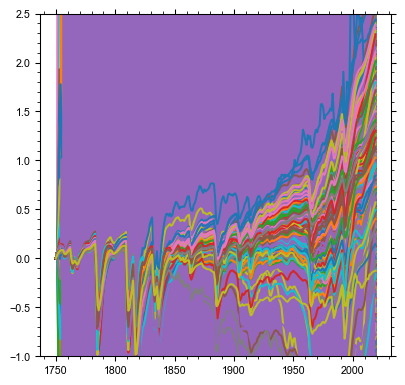

In [19]:
pl.plot(np.arange(1750,2020),results['CEDS-UPDATE']['surface_temperature']);
pl.ylim(-1, 2.5)

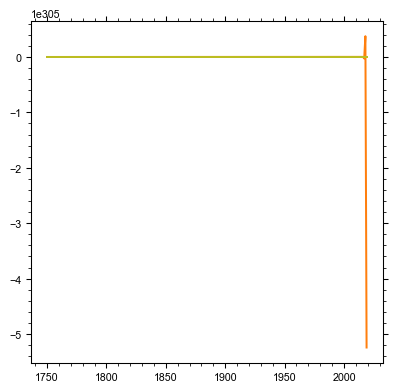

In [20]:
pl.plot(np.arange(1750,2020),results['CEDS-UPDATE']['deep_ocean_temperature']);

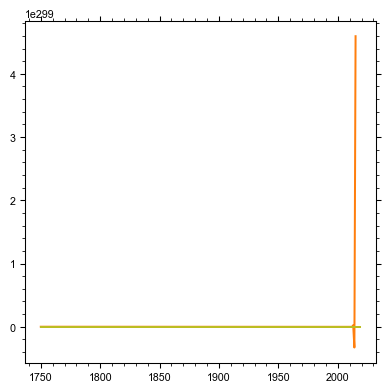

In [21]:
pl.plot(np.arange(1750,2020),results['CEDS-UPDATE']['net_energy_imbalance']);

(0.0, 1e+24)

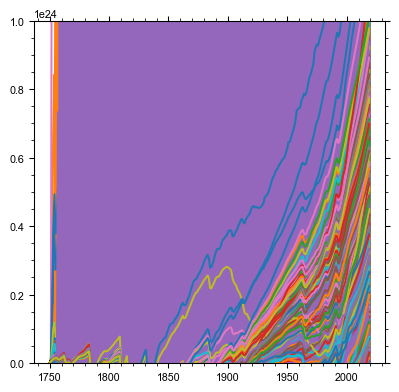

In [22]:
pl.plot(np.arange(1750,2020),results['CEDS-UPDATE']['ocean_heat_content']);
pl.ylim(0,1e24)

In [23]:
samples = 24019

In [25]:
temp_weight = knutti_score(
    Tobs,
    (
        results['CEDS-UPDATE']['surface_temperature'][100:269,:] + intvar[100:269,:samples] -
        np.mean(results['CEDS-UPDATE']['surface_temperature'][100:151,:] + intvar[100:151,:samples], axis=0)
    ),
    sigma_D=0.12
)
ohc_weight = simple_weight(
    (OHCobs[-1]-OHCobs[0])*1e21,
    (results['CEDS-UPDATE']['ocean_heat_content'][268,:]-results['CEDS-UPDATE']['ocean_heat_content'][221,:]),
    sigma_D=OHC90*1e21/NINETY_TO_ONESIGMA
)
results['CEDS-UPDATE']['ensemble_weight'] = (temp_weight * ohc_weight)/(np.sum(temp_weight * ohc_weight))

/nfs/b0110/Users/mencsm/ar6/src/ar6/utils/ensemble.py:67: RuntimeWarning: overflow encountered in square
  ks_raw = np.exp(-(mod-obs)**2/sigma_D**2)


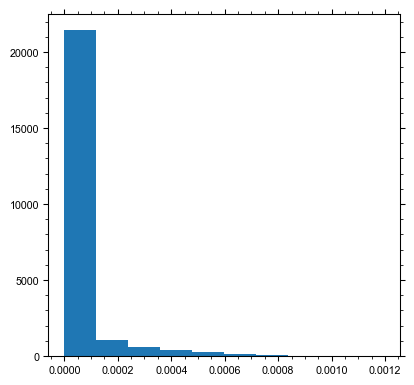

In [26]:
pl.hist(results['CEDS-UPDATE']['ensemble_weight']);

In [27]:
print(weighted_percentile(ERFari['CEDS-UPDATE'][268,:samples]+ERFaci['CEDS-UPDATE'][268,:samples], results['CEDS-UPDATE']['ensemble_weight'], [.05,.17,.5,.83,.95]))

[-1.3939689432584985, -1.1402534168252734, -0.8269818026238449, -0.5353628671209856, -0.3286936098547516]


In [28]:
save_dict_to_hdf5(results, '../data_input_large/twolayer_with_CEDS-UPDATE.h5')

# After runs, start here

In [29]:
pc = {}
pc['GSAT_1850-1900'] = {}
pc['OHC_1971'] = {}
pc['ERFari'] = {}
pc['ERFaci'] = {}
pc['ERFaer'] = {}
for perc in [5,16,50,84,95]:
    pc['ERFari'][perc] = np.zeros(270)
    pc['ERFaci'][perc] = np.zeros(270)
    pc['ERFaer'][perc] = np.zeros(270)
    pc['GSAT_1850-1900'][perc] = np.zeros(270)
    pc['OHC_1971'][perc] = np.zeros(270)
for year in range(270):
    (
        pc['GSAT_1850-1900'][5][year],
        pc['GSAT_1850-1900'][16][year],
        pc['GSAT_1850-1900'][50][year],
        pc['GSAT_1850-1900'][84][year],
        pc['GSAT_1850-1900'][95][year] 
    ) = weighted_percentile((results['CEDS-UPDATE']['surface_temperature'][year,:samples] + intvar[year,:samples])-np.mean(results['CEDS-UPDATE']['surface_temperature'][100:151,:samples] + intvar[100:151,:samples], axis=0), results['CEDS-UPDATE']['ensemble_weight'], [.05,.16,.5,.84,.95])
    (
        pc['OHC_1971'][5][year],
        pc['OHC_1971'][16][year],
        pc['OHC_1971'][50][year],
        pc['OHC_1971'][84][year],
        pc['OHC_1971'][95][year] 
    ) = weighted_percentile(results['CEDS-UPDATE']['ocean_heat_content'][year,:samples]-results['CEDS-UPDATE']['ocean_heat_content'][221,:samples], results['CEDS-UPDATE']['ensemble_weight'], [.05,.16,.5,.84,.95])
    (
        pc['ERFari'][5][year],
        pc['ERFari'][16][year],
        pc['ERFari'][50][year],
        pc['ERFari'][84][year],
        pc['ERFari'][95][year] 
    ) = weighted_percentile(ERFari['CEDS-UPDATE'][year,:samples], results['CEDS-UPDATE']['ensemble_weight'], [.05,.16,.5,.84,.95])
    (
        pc['ERFaci'][5][year],
        pc['ERFaci'][16][year],
        pc['ERFaci'][50][year],
        pc['ERFaci'][84][year],
        pc['ERFaci'][95][year] 
    ) = weighted_percentile(ERFaci['CEDS-UPDATE'][year,:samples], results['CEDS-UPDATE']['ensemble_weight'], [.05,.16,.5,.84,.95])
    (
        pc['ERFaer'][5][year],
        pc['ERFaer'][16][year],
        pc['ERFaer'][50][year],
        pc['ERFaer'][84][year],
        pc['ERFaer'][95][year] 
    ) = weighted_percentile(ERFari['CEDS-UPDATE'][year,:samples]+ERFaci['CEDS-UPDATE'][year,:samples], results['CEDS-UPDATE']['ensemble_weight'], [.05,.16,.5,.84,.95])

In [30]:
print('ERFaer', '%4.2f %4.2f %4.2f %4.2f %4.2f' % (pc['ERFaer'][5][269], pc['ERFaer'][16][269], pc['ERFaer'][50][269], pc['ERFaer'][84][269], pc['ERFaer'][95][269]))
print('ERFari', '%4.2f %4.2f %4.2f %4.2f %4.2f' % (pc['ERFari'][5][269], pc['ERFari'][16][269], pc['ERFari'][50][269], pc['ERFari'][84][269], pc['ERFari'][95][269]))
print('ERFaci', '%4.2f %4.2f %4.2f %4.2f %4.2f' % (pc['ERFaci'][5][269], pc['ERFaci'][16][269], pc['ERFaci'][50][269], pc['ERFaci'][84][269], pc['ERFaci'][95][269]))
print()
print('---------')
print('ERFaer', np.percentile(ERFari['CEDS-UPDATE'][269,:]+ERFaci['CEDS-UPDATE'][269,:], (5,16,50,84,95)))
print('ERFari', np.percentile(ERFari['CEDS-UPDATE'][269,:], (5,16,50,84,95)))
print('ERFaci', np.percentile(ERFaci['CEDS-UPDATE'][269,:], (5,16,50,84,95)))

ERFaer -1.39 -1.15 -0.82 -0.52 -0.33
ERFari -0.60 -0.44 -0.28 -0.15 -0.08
ERFaci -1.09 -0.84 -0.51 -0.24 -0.08

---------
ERFaer [-3.12760367 -2.09873403 -1.06895631 -0.49484329 -0.22561426]
ERFari [-0.69179694 -0.50312143 -0.30089565 -0.13955146 -0.01421576]
ERFaci [-2.62459971 -1.69835339 -0.75279322 -0.25311185 -0.05746119]


/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply


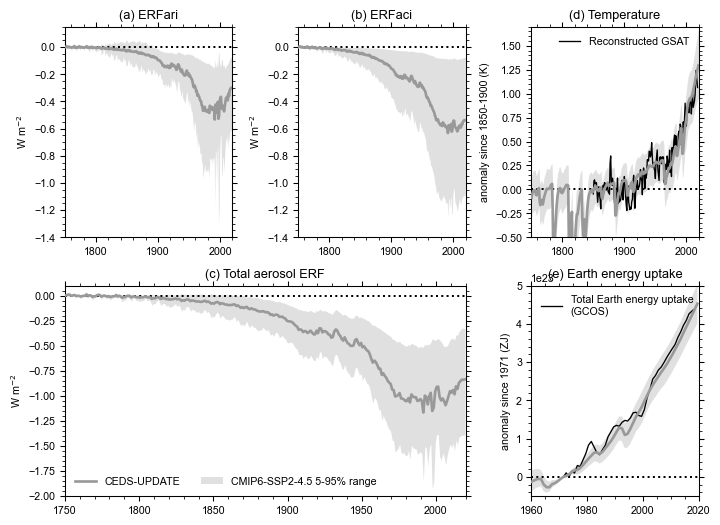

In [31]:
#fig, ax = pl.subplots(3,2,figsize=(16/2.54,23/2.54))
fig = pl.figure(figsize=(19/2.54,14/2.54))
gs = gridspec.GridSpec(ncols=6, nrows=2)
axtmp = fig.add_subplot(gs[0,4:6])
axohc = fig.add_subplot(gs[1,4:6])
axari = fig.add_subplot(gs[0,0:2])
axaci = fig.add_subplot(gs[0,2:4])
axaer = fig.add_subplot(gs[1,0:4])

expt='CEDS-UPDATE'
axtmp.fill_between(np.arange(1750.5,2020), pc['GSAT_1850-1900'][5], pc['GSAT_1850-1900'][95], color='0.6', alpha=0.3, lw=0)
axaer.fill_between(np.arange(1750.5,2020), pc['ERFaer'][5], pc['ERFaer'][95], color='0.6', alpha=0.3, lw=0, label='CMIP6-SSP2-4.5 5-95% range')
axari.fill_between(np.arange(1750.5,2020), pc['ERFari'][5], pc['ERFari'][95], color='0.6', alpha=0.3, lw=0)
axaci.fill_between(np.arange(1750.5,2020), pc['ERFaci'][5], pc['ERFaci'][95], color='0.6', alpha=0.3, lw=0)
axohc.fill_between(np.arange(1750.5,2020), pc['OHC_1971'][5], pc['OHC_1971'][95], color='0.6', alpha=0.3, lw=0)

lw=2
zorder=10
axtmp.plot(np.arange(1750.5,2020), np.nansum(((results['CEDS-UPDATE']['surface_temperature'] + intvar[:,:samples])-np.mean(results['CEDS-UPDATE']['surface_temperature'][100:151] + intvar[100:151,:samples], axis=0))*results['CEDS-UPDATE']['ensemble_weight'], axis=1), lw=lw, color='0.6', zorder=zorder)
axaer.plot(np.arange(1750.5,2020), np.nansum((ERFari['CEDS-UPDATE'][:270,:samples]+ERFaci['CEDS-UPDATE'][:270,:samples])*results['CEDS-UPDATE']['ensemble_weight'], axis=1), lw=lw, label=expt, color='0.6', zorder=zorder)
axari.plot(np.arange(1750.5,2020), np.nansum((ERFari['CEDS-UPDATE'][:270,:samples])*results['CEDS-UPDATE']['ensemble_weight'], axis=1), lw=lw, label=expt, color='0.6', zorder=zorder)
axaci.plot(np.arange(1750.5,2020), np.nansum((ERFaci['CEDS-UPDATE'][:270,:samples])*results['CEDS-UPDATE']['ensemble_weight'], axis=1), lw=lw, label=expt, color='0.6', zorder=zorder)
axohc.plot(np.arange(1750.5,2020), np.nansum((results['CEDS-UPDATE']['ocean_heat_content']-results['CEDS-UPDATE']['ocean_heat_content'][221,:])*results['CEDS-UPDATE']['ensemble_weight'], axis=1), lw=lw, color='0.6', zorder=zorder)

# #axaer.plot(np.arange(1750.5,2020), savgol_filter(np.nansum((ERFari[expt][:270]+ERFaci[expt][:270])*ks['multi'][expt], axis=1), 11, 1), label=expt, color=colors[expt])
axtmp.plot(years, Tobs, color='k', label='Reconstructed GSAT', lw=1)
axohc.plot(np.arange(1971.5,2019), (OHCobs-OHCobs[0])*1e21, color='k', lw=1, label='Total Earth energy uptake\n(GCOS)')
axtmp.legend(frameon=False)
axohc.legend(frameon=False, loc='upper left')
axtmp.set_xlim(1750,2020)
axtmp.set_ylim(-0.5,1.7)
axtmp.set_ylabel('anomaly since 1850-1900 (K)');
axtmp.set_title('(d) Temperature')
axtmp.axhline(0, ls=':', color='k')
axohc.axhline(0, ls=':', color='k')
axohc.set_ylabel('anomaly since 1971 (ZJ)')
axohc.set_title('(e) Earth energy uptake')
axohc.set_ylim(-50e21,500e21)
axohc.set_xlim(1960,2020)
axaer.set_xlim(1750,2020)
axaer.set_ylim(-2.0,0.1)
axaer.set_ylabel('W m$^{-2}$');
axaer.set_title('(c) Total aerosol ERF')
axaer.axhline(0, ls=':', color='k')
axaer.legend(fontsize=8, frameon=False, ncol=2);
axari.set_xlim(1750,2020)
axari.set_ylim(-1.4,0.15)
axari.set_ylabel('W m$^{-2}$');
axari.set_title('(a) ERFari')
axari.axhline(0, ls=':', color='k')
axaci.set_xlim(1750,2020)
axaci.set_ylim(-1.4,0.15)
axaci.set_ylabel('W m$^{-2}$');
axaci.set_title('(b) ERFaci')
axaci.axhline(0, ls=':', color='k')
fig.tight_layout()

In [32]:
year = np.arange(1750,2020)
erfaer = np.nansum((ERFari['CEDS-UPDATE'][:270,:samples]+ERFaci['CEDS-UPDATE'][:270,:samples])*results['CEDS-UPDATE']['ensemble_weight'], axis=1)
erfaer05 = pc['ERFaer'][5]
erfaer16 = pc['ERFaer'][16]
erfaer50 = pc['ERFaer'][50]
erfaer84 = pc['ERFaer'][84]
erfaer95 = pc['ERFaer'][95]
df = pd.DataFrame(data=np.array([year, erfaer05, erfaer16, erfaer, erfaer50, erfaer84, erfaer95]).T, columns =['year','pc05','pc16','mean','pc50','pc84','pc95'])
df = df.astype({'year':int})
df.set_index('year', inplace=True)
df.to_csv('../data_output/aerosol_forcing.csv')
df

,pc05,pc16,mean,pc50,pc84,pc95
year,,,,,,
1750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1751,-0.004925,0.000458,0.006127,0.004976,0.012784,0.021221
1752,-0.008201,0.000715,0.009980,0.008148,0.020979,0.035047
1753,-0.005074,0.000331,0.006087,0.004809,0.012908,0.021664
1754,-0.011142,-0.006991,-0.003430,-0.003007,-0.000458,0.002412
1755,-0.002860,-0.000269,0.002162,0.001700,0.005214,0.009053
1756,-0.004864,0.000043,0.005305,0.004123,0.011758,0.019726
1757,-0.018097,-0.010971,-0.005656,-0.004601,-0.000747,0.002810
1758,-0.004936,-0.003072,-0.001470,-0.001113,-0.000078,0.000866


In [33]:
erfari = np.nansum((ERFari['CEDS-UPDATE'][:270,:samples])*results['CEDS-UPDATE']['ensemble_weight'], axis=1)
erfari05 = pc['ERFari'][5]
erfari16 = pc['ERFari'][16]
erfari50 = pc['ERFari'][50]
erfari84 = pc['ERFari'][84]
erfari95 = pc['ERFari'][95]
df = pd.DataFrame(data=np.array([year, erfari05, erfari16, erfari, erfari50, erfari84, erfari95]).T, columns =['year','pc05','pc16','mean','pc50','pc84','pc95'])
df = df.astype({'year':int})
df.set_index('year', inplace=True)
df.to_csv('../data_output/aerosol_forcing_ERFari.csv')
df

,pc05,pc16,mean,pc50,pc84,pc95
year,,,,,,
1750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1751,-0.006875,-0.001206,0.002977,0.002073,0.007864,0.016180
1752,-0.011512,-0.001970,0.005028,0.003475,0.013341,0.027117
1753,-0.007084,-0.001265,0.002996,0.002070,0.007988,0.016465
1754,-0.009489,-0.004752,-0.001817,-0.001278,0.000498,0.003738
1755,-0.003430,-0.000582,0.001435,0.000982,0.003996,0.008107
1756,-0.006189,-0.001253,0.002568,0.001772,0.006994,0.014336
1757,-0.010259,-0.005279,-0.001891,-0.001393,0.000976,0.005088
1758,-0.001733,-0.000821,-0.000123,-0.000101,0.000616,0.001496


In [34]:
erfaci = np.nansum((ERFaci['CEDS-UPDATE'][:270,:samples])*results['CEDS-UPDATE']['ensemble_weight'], axis=1)
erfaci05 = pc['ERFaci'][5]
erfaci16 = pc['ERFaci'][16]
erfaci50 = pc['ERFaci'][50]
erfaci84 = pc['ERFaci'][84]
erfaci95 = pc['ERFaci'][95]
df = pd.DataFrame(data=np.array([year, erfaci05, erfaci16, erfaci, erfaci50, erfaci84, erfaci95]).T, columns =['year','pc05','pc16','mean','pc50','pc84','pc95'])
df = df.astype({'year':int})
df.set_index('year', inplace=True)
df.to_csv('../data_output/aerosol_forcing_ERFaci.csv')
df

,pc05,pc16,mean,pc50,pc84,pc95
year,,,,,,
1750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1751,0.000114,0.000338,0.003149,0.001409,0.006280,0.012039
1752,0.000160,0.000510,0.004952,0.002198,0.009775,0.019008
1753,0.000096,0.000296,0.003092,0.001271,0.006230,0.012291
1754,-0.005411,-0.003115,-0.001613,-0.000994,-0.000226,-0.000077
1755,-0.000312,-0.000098,0.000727,0.000135,0.001748,0.003628
1756,0.000047,0.000135,0.002737,0.000790,0.005861,0.011743
1757,-0.013030,-0.007405,-0.003766,-0.001997,-0.000549,-0.000195
1758,-0.004241,-0.002598,-0.001347,-0.000849,-0.000268,-0.000090


In [ ]:
# print(np.mean(pc['ECLIPSE-constrained']['multi']['ERFaer'][95][255:265]))
# print(np.mean(pc['ECLIPSE-constrained']['multi']['ERFaer'][50][255:265]))
# print(np.mean(pc['ECLIPSE-constrained']['multi']['ERFaer'][5][255:265]))